In [153]:
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryAccuracy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [154]:
device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

In [155]:
df = pd.read_csv('datasets/riceClassification.csv')

In [156]:
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [157]:
df.isna().sum()

id                 0
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Perimeter          0
Roundness          0
AspectRation       0
Class              0
dtype: int64

In [158]:
df.duplicated().sum()

np.int64(0)

In [159]:
df.drop(columns='id', inplace=True)

In [160]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [161]:
df.shape

(18185, 11)

In [162]:
df['Class'].value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

In [163]:
original_df = df.copy()

In [164]:
for column in df.columns:
    df[column] = df[column]/df[column].abs().max()

df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [165]:
X = df.drop(columns='Class')
y = df['Class']

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [167]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [168]:
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(12729,)
(2728,)
(2728,)


In [169]:
X_train_t = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_t = torch.tensor(y_train.to_numpy(), dtype=torch.float32)

X_val_t = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
y_val_t = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

X_test_t = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_t = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [170]:
train_data = TensorDataset(X_train_t, y_train_t)
val_data   = TensorDataset(X_val_t, y_val_t)
test_data  = TensorDataset(X_test_t, y_test_t)

In [171]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=8)
test_loader  = DataLoader(test_data, batch_size=8)

In [172]:
HIDDEN_NEURONS = 24

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x 

model = NeuralNet()
model

NeuralNet(
  (input_layer): Linear(in_features=10, out_features=24, bias=True)
  (linear): Linear(in_features=24, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [173]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]             264
            Linear-2                    [-1, 1]              25
           Sigmoid-3                    [-1, 1]               0
Total params: 289
Trainable params: 289
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [174]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [177]:
def plot_loss_curves(epochs_count, training_loss_values, testing_loss_values):
    train_loss = np.array(training_loss_values)
    test_loss = np.array(testing_loss_values)

    epochs_range = range(1, epochs_count + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, test_loss, label='Validation Loss')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 01 | Train Loss: 0.0435 | Val Loss: 0.0333 | Acc: 0.9894
Epoch 02 | Train Loss: 0.0435 | Val Loss: 0.0329 | Acc: 0.9901
Epoch 03 | Train Loss: 0.0429 | Val Loss: 0.0343 | Acc: 0.9890
Epoch 04 | Train Loss: 0.0429 | Val Loss: 0.0362 | Acc: 0.9890
Epoch 05 | Train Loss: 0.0433 | Val Loss: 0.0327 | Acc: 0.9901
Epoch 06 | Train Loss: 0.0429 | Val Loss: 0.0333 | Acc: 0.9890
Epoch 07 | Train Loss: 0.0429 | Val Loss: 0.0346 | Acc: 0.9886
Epoch 08 | Train Loss: 0.0420 | Val Loss: 0.0437 | Acc: 0.9846
Epoch 09 | Train Loss: 0.0434 | Val Loss: 0.0326 | Acc: 0.9905
Epoch 10 | Train Loss: 0.0419 | Val Loss: 0.0334 | Acc: 0.9890


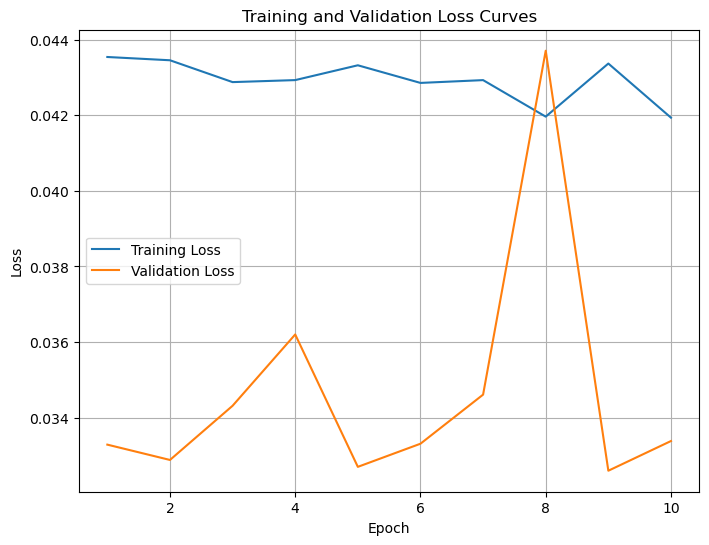

In [179]:
epochs = 10
model.to(device)
accuracy = BinaryAccuracy().to(device)

training_loss_values = []
testing_loss_values = []

for epoch in range(epochs):
    model.train()
    train_loss_total = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        y_pred_train = model(X).view(-1)
        loss_train = criterion(y_pred_train, y)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        train_loss_total += loss_train.item()

    model.eval()
    accuracy.reset()
    val_loss = 0.0
    with torch.inference_mode():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            y_pred_val = model(X).view(-1)
            loss_val = criterion(y_pred_val, y)
            val_loss += loss_val.item()
            accuracy.update((y_pred_val > 0.5).float(), y.int())

    avg_train_loss = train_loss_total / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    training_loss_values.append(avg_train_loss)
    testing_loss_values.append(avg_val_loss)

    acc = accuracy.compute()
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f}")

plot_loss_curves(epochs, training_loss_values, testing_loss_values)

In [180]:
model.state_dict()

OrderedDict([('input_layer.weight',
              tensor([[-0.7509,  0.2480, -0.3074,  0.1155, -0.4415, -0.3789, -0.0229,  0.2851,
                       -0.5036,  1.0609],
                      [ 0.6293, -0.4758,  0.3041, -0.4607,  0.3142,  0.5149, -0.2961,  0.2136,
                        0.2685, -0.7084],
                      [ 0.7738, -0.3588,  0.5608, -0.3967,  0.7218,  0.2457,  0.1628, -0.3910,
                        0.5592, -1.1648],
                      [ 0.7071, -0.1594,  0.5534, -0.3525,  0.6585,  0.2036, -0.1303, -0.2680,
                        0.5858, -1.0325],
                      [ 0.3815, -0.1465,  0.3816, -0.5558,  0.6534,  0.2303,  0.1200, -0.3953,
                        0.3917, -1.0250],
                      [-0.7291,  0.3577, -0.4529,  0.3349, -0.6998, -0.3999, -0.2385,  0.0597,
                        0.0521,  0.5409],
                      [ 0.7132, -0.2203,  0.5323, -0.5105,  0.8686,  0.3239, -0.1141, -0.1807,
                        0.5778, -1.2031],
     